## Setup

In [1]:
from IPython import get_ipython # type: ignore
ipython = get_ipython(); assert ipython is not None
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

# Standard imports
import os
import torch
import numpy as np
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import einops
from jaxtyping import Float, Int
from torch import Tensor

torch.set_grad_enabled(False)

# Device setup
GPU_TO_USE = 1

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = f"cuda:{GPU_TO_USE}" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

# utility to clear variables out of the memory & and clearing cuda cache
import gc
def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

Device: cuda:1


In [2]:
from pathlib import Path
import sys
import os

def get_base_folder(project_root = "tim-taras-sfc-errors"):
	# Find the project root dynamically
	current_dir = os.getcwd()
	while True:
		if os.path.basename(current_dir) == project_root:  # Adjust to match your project root folder name
			break
		parent = os.path.dirname(current_dir)
		if parent == current_dir:  # Stop if we reach the system root (failsafe)
			raise RuntimeError(f"Project root {project_root} not found. Check your folder structure.")
		current_dir = parent

	return current_dir

def get_project_folder(base_folder=None, project_folder_name='sfc-errors'):
	if base_folder is None:
		base_folder = get_base_folder()
	
	return Path(base_folder) / project_folder_name

def get_data_path(base_folder=None, data_folder_name='data'):
	if base_folder is None:
		base_folder = get_base_folder()

	return Path(base_folder) / data_folder_name

In [3]:
base_path = get_base_folder()
print(f"Base path: {base_path}")

project_path = get_project_folder(base_folder=base_path)
print(f"Project path: {project_path}")

sys.path.append(base_path)
sys.path.append(str(project_path))

Base path: /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors
Project path: /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/sfc-errors


In [4]:
datapath = get_data_path(base_path) 
datapath

PosixPath('/mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/data')

## Loading the model

We'll work with Gemma-2 2B (base version)

In [5]:
from sae_lens import SAE, HookedSAETransformer, ActivationsStore

USE_INSTRUCT = False
PARAMS_COUNT = 2

MODEL_NAME = f'gemma-2-{PARAMS_COUNT}b' + ('-it' if USE_INSTRUCT else '')
print(f'Using {MODEL_NAME}')

model = HookedSAETransformer.from_pretrained(MODEL_NAME, device=device, dtype=torch.bfloat16)
model

Using gemma-2-2b


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


HookedSAETransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-25): 26 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln1_post): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2_post): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
      

## Loading the data

This uses my custom dataloader class, which parses raw data and prepares into a nice format for SFC, including providing some useful metadata such as token positions for where the answer should be, attention masks etc. The details of the class are convoluted because it was developed for a more general purpose than verb agreement tasks, so you can largely ignore the next few cells.

In [6]:
from classes.sfc_data_loader import SFCDatasetLoader
import utils.prompts as prompts
from utils.enums import *

In [7]:
DATASET_NAME = SupportedDatasets.VERB_AGREEMENT_TEST

dataloader = SFCDatasetLoader(DATASET_NAME, model,
                              local_dataset=True, base_folder_path=datapath)

In [8]:
clean_dataset, corrupted_dataset = dataloader.get_clean_corrupted_datasets(tokenize=True, apply_chat_template=False, prepend_generation_prefix=True)

Dataset SupportedDatasets.VERB_AGREEMENT_TEST has constant length prompts. Skipping padding calculation.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25269/25269 [00:32<00:00, 768.26it/s]


- Corrupted dataset here refers to the collection of patched prompts and their answers (verb completions) in the SFC paper terminology.
- The datasets support padding but currently its logic doesn't work well with templatic datasets like this, gotta fix it later **TODO**

In [9]:
CONTROL_SEQ_LEN = clean_dataset['control_sequence_length'][0].item() # how many first tokens to ignore when computing SFC scores
N_CONTEXT = clean_dataset['prompt'].shape[1]

CONTROL_SEQ_LEN, N_CONTEXT

(2, 7)

In [10]:
print('Clean dataset:')
for prompt in clean_dataset['prompt'][:3]:
  print("\nPrompt:", model.to_string(prompt), end='\n\n')

  for i, tok in enumerate(prompt):
    str_token = model.to_string(tok)
    print(f"({i-CONTROL_SEQ_LEN}, {str_token})", end=' ')
  print()

print('Corrupted dataset:')
for prompt in corrupted_dataset['prompt'][:3]:
  print("\nPrompt:", model.to_string(prompt), end='\n\n')
  
  for i, tok in enumerate(prompt):
    str_token = model.to_string(tok)
    print(f"({i-CONTROL_SEQ_LEN}, {str_token})", end=' ')
  print()

Clean dataset:

Prompt: <bos>The doctors that the assistant follows

(-2, <bos>) (-1, The) (0,  doctors) (1,  that) (2,  the) (3,  assistant) (4,  follows) 

Prompt: <bos>The victim that the executive follows

(-2, <bos>) (-1, The) (0,  victim) (1,  that) (2,  the) (3,  executive) (4,  follows) 

Prompt: <bos>The poets that the parents hate

(-2, <bos>) (-1, The) (0,  poets) (1,  that) (2,  the) (3,  parents) (4,  hate) 
Corrupted dataset:

Prompt: <bos>The doctor that the assistant follows

(-2, <bos>) (-1, The) (0,  doctor) (1,  that) (2,  the) (3,  assistant) (4,  follows) 

Prompt: <bos>The victims that the executive follows

(-2, <bos>) (-1, The) (0,  victims) (1,  that) (2,  the) (3,  executive) (4,  follows) 

Prompt: <bos>The poet that the parents hate

(-2, <bos>) (-1, The) (0,  poet) (1,  that) (2,  the) (3,  parents) (4,  hate) 


In [11]:
# Sanity checks

# Control sequence length must be the same for all samples in both datasets
clean_ds_control_len = clean_dataset['control_sequence_length']
corrupted_ds_control_len = corrupted_dataset['control_sequence_length']

assert torch.all(corrupted_ds_control_len == corrupted_ds_control_len[0]), "Control sequence length is not the same for all samples in the dataset"
assert torch.all(clean_ds_control_len == clean_ds_control_len[0]), "Control sequence length is not the same for all samples in the dataset"
assert clean_ds_control_len[0] == corrupted_ds_control_len[0], "Control sequence length is not the same for clean and corrupted samples in the dataset"
assert clean_dataset['answer'].max().item() < model.cfg.d_vocab, "Clean answers exceed vocab size"
assert corrupted_dataset['answer'].max().item() < model.cfg.d_vocab, "Patched answers exceed vocab size"
assert (clean_dataset['answer_pos'] < N_CONTEXT).all().item(), "Answer positions exceed logits length"
assert (corrupted_dataset['answer_pos'] < N_CONTEXT).all().item(), "Answer positions exceed logits length"

# Setting up the SAEs

In [12]:
from classes.sfc_model import *

RUN_WITH_SAES = True # we'll run the model with attached SAEs to automatically compute error scores and patch w.r.t. them

# So there will be no caching device (everything we'll be done on a single GPU)
if RUN_WITH_SAES:
    caching_device = device 
else:
    caching_device = "cuda:2"


caching_device

'cuda:1'

I'll use my custom `SFC_Gemma` class. In short, it
- Loads a Gemma model and its Gemma Scope SAEs (either attaching them to the model or not)
- Provides interface methods for computing SFC scores **and activation patching** scores

In [13]:
clear_cache()

sfc_model = SFC_Gemma(model, params_count=PARAMS_COUNT, control_seq_len=CONTROL_SEQ_LEN, 
                      attach_saes=RUN_WITH_SAES, caching_device=caching_device)
sfc_model.print_saes()

clear_cache()

# sfc_model.model.cfg
# , sfc_model.saes[0].cfg.dtype

Using 16K SAEs for the first 26 layers, the rest 0 layer(s) - 131k SAEs
Number of SAEs: 78
blocks.0.hook_resid_post SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)
blocks.1.hook_resid_post SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)
blocks.2.hook_resid_post SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)
blocks.3.hook_resid_post SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_s

# Activation patching

In [16]:
# Define the patching config

N_LAYERS = sfc_model.n_layers

layers_to_patch={
        'resid': list(range(N_LAYERS)),
        # 'mlp': list(range(N_LAYERS)),
        # 'attn': list(range(N_LAYERS))
    }
token_specific_error_types = ['resid']
token_positions = [2, 3, -1]

In [17]:
batch_size = 900
total_batches = None

# Reset the hooks to avoid weird bugs
sfc_model.model.reset_hooks()
if RUN_WITH_SAES:
    sfc_model._reset_sae_hooks()
clear_cache()

# Compute the patching effects for each type of error (resid, mlp, attn)
patching_effects = sfc_model.compute_act_patching_scores_for_errors(clean_dataset, corrupted_dataset, 
                                                                    layers_to_patch=layers_to_patch, 
                                                                    token_specific_error_types=token_specific_error_types,
                                                                    token_positions=token_positions,
																	batch_size=batch_size, total_batches=total_batches)

patching_effects.keys()

---
Samples 0/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 900/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 1800/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 2700/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 3600/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 4500/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 5400/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 6300/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 7200/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 8100/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 9000/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 9900/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 10800/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 11700/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 12600/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 13500/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 14400/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 15300/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 16200/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 17100/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 18000/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 18900/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 19800/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 20700/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 21600/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 22500/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 23400/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 24300/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 25200/25269
---
Computing patching effect for resid errors...
  Using token-specific patching for 3 positions


  0%|          | 0/26 [00:00<?, ?it/s]

dict_keys(['resid', 'mlp', 'attn'])

In [18]:
# Each error type should have the number of "patching effects" equal to the number of layers
patching_effects['resid'].shape #, patching_effects['mlp'].shape, patching_effects['attn'].shape 

torch.Size([26, 7])

In [19]:
def save_dict(data_dict, dataset_name='sva', prefix=''):   
    filename = f'{dataset_name}_{prefix}_act_patching_scores.pkl'
     
    print(f'Saving {filename}...')
    filename = datapath / filename

    # Save using torch.save, which properly handles tensor storage details
    torch.save(data_dict, filename)

In [20]:
save_dict(patching_effects['resid'], prefix='resid')
# save_dict(patching_effects['mlp'], prefix='mlp') 
# save_dict(patching_effects['attn'], prefix='attn') 

Saving sva_resid_act_patching_scores.pkl...


# Patching results analysis

#### Setup x2 for running the notebook from this section (don't read)

In [1]:
from IPython import get_ipython # type: ignore
ipython = get_ipython(); assert ipython is not None
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

# Standard imports
import os
import torch
import numpy as np
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import einops
from jaxtyping import Float, Int
from torch import Tensor

torch.set_grad_enabled(False)

# Device setup
GPU_TO_USE = 1

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = f"cuda:{GPU_TO_USE}" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

# utility to clear variables out of the memory & and clearing cuda cache
import gc
def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

from pathlib import Path
import sys
import os

def get_base_folder(parent_dir_name =  "tim-taras-sfc-errors"):
	# Find the project root dynamically
	current_dir = os.getcwd()
	while True:
		if os.path.basename(current_dir) == parent_dir_name:  # Adjust to match your project root folder name
			break
		parent = os.path.dirname(current_dir)
		if parent == current_dir:  # Stop if we reach the system root (failsafe)
			raise RuntimeError(f"Project root {parent_dir_name} not found. Check your folder structure.")
		current_dir = parent

	return current_dir

def get_data_path(base_folder=None, data_folder_name='data'):
	if base_folder is None:
		base_folder = get_base_folder()

	return Path(base_folder) / data_folder_name

def get_project_folder(base_folder=None, project_folder_name='sfc-errors'):
	if base_folder is None:
		base_folder = get_base_folder()
	
	return Path(base_folder) / project_folder_name

base_path = get_base_folder()
print(f"Base path: {base_path}")

project_path = get_project_folder(base_folder=base_path)
print(f"Project path: {project_path}")

# Add the parent directory (sfc_deception) to sys.path
sys.path.append(base_path)
sys.path.append(str(project_path))

datapath = get_data_path(base_path) 
datapath

Device: cuda:1
Base path: /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors
Project path: /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/sfc-errors


PosixPath('/mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/data')

Load error node scores:
- SFC scores (attribution patching)
- Activation patching scores

In [30]:
def load_act_patching_scores(dataset_name='sva', prefix=''):
    filename = f'{dataset_name}_{prefix}_act_patching_scores.pkl'
    print(f'Loading {filename}...')
    filename = datapath / filename

    # Use torch.load with map_location to force loading on the desired device
    data_dict = torch.load(filename, map_location=torch.device(device))
    return data_dict

def load_sfc_scores(experiment_name='sva_rc', device=device):
	from classes.sfc_node_scores import SFC_NodeScores

	sfc_scores = SFC_NodeScores(
		device=device,
		data_dir=datapath,
		experiment_name=experiment_name,
		load_if_exists=True  # This will automatically load our computed scores
	)
	return sfc_scores.node_scores

sfc_scores = load_sfc_scores('sva_rc_test')

resid_patching_scores = load_act_patching_scores(prefix='resid')
mlp_patching_scores = load_act_patching_scores(prefix='mlp') 
attn_patching_scores = load_act_patching_scores(prefix='attn') 

resid_patching_scores.shape, mlp_patching_scores.shape, attn_patching_scores.shape

Loaded SFC scores from /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/data/sva_rc_test/sfc_scores.pkl
Loaded mean activations from /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/data/sva_rc_test/mean_activations.pkl
Loading sva_resid_act_patching_scores.pkl...
Loading sva_mlp_act_patching_scores.pkl...
Loading sva_attn_act_patching_scores.pkl...


(torch.Size([26, 7]), torch.Size([26, 8]), torch.Size([26, 8]))

In [31]:
N_LAYERS = 26 

# Extract the error scores from the scores dict of all SFC nodes
resid_sfc_scores = [sfc_scores[f'blocks.{k}.hook_resid_post.hook_sae_error'] for k in range(N_LAYERS)]
mlp_sfc_scores = [sfc_scores[f'blocks.{k}.hook_mlp_out.hook_sae_error'] for k in range(N_LAYERS)]
attn_sfc_scores = [sfc_scores[f'blocks.{k}.attn.hook_z.hook_sae_error'] for k in range(N_LAYERS)]

### Plotting all of the act-patching and SFC scores together

In [61]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

def plot_scores(
    resid_sfc_scores, 
    mlp_sfc_scores, 
    attn_sfc_scores,
    resid_patching_scores, 
    mlp_patching_scores, 
    attn_patching_scores,
    token_positions=None,
    prompt="BOS The girls that the assistants hate",
    title_suffix=""
):
    """
    Plot AtP and patching scores across layers for multiple token positions.
    """
    token_list = prompt.split()
    if token_positions is None:
        token_positions = [None]

    n_rows = len(token_positions)
    fig = make_subplots(
        rows=n_rows, cols=2,
        subplot_titles=[f"AtP Scores", "Patching Scores"] * n_rows,
        shared_xaxes=False, shared_yaxes=False,
        horizontal_spacing=0.1,
        vertical_spacing=0.2
    )

    colors = {'Residual': 'blue', 'MLP': 'red', 'Attention': 'green'}
    layer_indices = list(range(len(resid_sfc_scores)))

    for i, pos in enumerate(token_positions):
        if pos is not None:
            try:
                token_str = token_list[pos]
            except IndexError:
                token_str = f"<pos {pos}>"
            position_desc = f"Token {pos} (‘{token_str}’)"
            resid_sfc_values = [tensor[pos].float().cpu().numpy() for tensor in resid_sfc_scores]
            mlp_sfc_values = [tensor[pos].float().cpu().numpy() for tensor in mlp_sfc_scores]
            attn_sfc_values = [tensor[pos].float().cpu().numpy() for tensor in attn_sfc_scores]

            resid_patching_values = [tensor[pos].float().cpu().numpy() for tensor in resid_patching_scores]
            mlp_patching_values = [tensor[pos].float().cpu().numpy() for tensor in mlp_patching_scores]
            attn_patching_values = [tensor[pos].float().cpu().numpy() for tensor in attn_patching_scores]
        else:
            position_desc = "Averaged over tokens"
            resid_sfc_values = [tensor.float().mean(dim=0).cpu().numpy() for tensor in resid_sfc_scores]
            mlp_sfc_values = [tensor.float().mean(dim=0).cpu().numpy() for tensor in mlp_sfc_scores]
            attn_sfc_values = [tensor.float().mean(dim=0).cpu().numpy() for tensor in attn_sfc_scores]

            resid_patching_values = [tensor.float().mean(dim=0).cpu().numpy() for tensor in resid_patching_scores]
            mlp_patching_values = [tensor.float().mean(dim=0).cpu().numpy() for tensor in mlp_patching_scores]
            attn_patching_values = [tensor.float().mean(dim=0).cpu().numpy() for tensor in attn_patching_scores]

        row = i + 1

        # AtP subplot
        for score_values, label in zip(
            [resid_sfc_values, mlp_sfc_values, attn_sfc_values],
            ['Residual', 'MLP', 'Attention']
        ):
            fig.add_trace(go.Scatter(
                x=layer_indices,
                y=score_values,
                mode='lines+markers',
                name=f'{label} – {position_desc}',
                line=dict(color=colors[label])
            ), row=row, col=1)

        # Patching subplot
        for score_values, label in zip(
            [resid_patching_values, mlp_patching_values, attn_patching_values],
            ['Residual', 'MLP', 'Attention']
        ):
            fig.add_trace(go.Scatter(
                x=layer_indices,
                y=score_values,
                mode='lines+markers',
                name=f'{label} – {position_desc}',
                line=dict(color=colors[label]),
                showlegend=False  # Prevent duplicate legends
            ), row=row, col=2)

        # Update titles
        fig.layout.annotations[2 * i + 0].update(
            text=f"{position_desc}: AtP Scores"
        )
        fig.layout.annotations[2 * i + 1].update(
            text=f"{position_desc}: Patching Scores"
        )

    # Main title
    title = f"AtP & Patching Scores across Layers for Different Token Positions"
    if title_suffix:
        title += f" – {title_suffix}"

    fig.update_layout(
        title=title,
        height=300 * n_rows,
        template='plotly_white',
        showlegend=True,
        legend_title="Component"
    )

    # Shared x-axis on bottom row
    fig.update_xaxes(title_text="Layer Index", row=n_rows, col=1)
    fig.update_xaxes(title_text="Layer Index", row=n_rows, col=2)

    # Add shared Y-axis label
    fig.add_annotation(
        text="Scores",
        xref="paper", yref="paper",
        x=-0.06, y=0.5,
        showarrow=False,
        textangle=-90,
        font=dict(size=14)
    )

    x_range = [min(layer_indices), max(layer_indices)]
    
    for i in range(1, n_rows + 1):
        fig.update_xaxes(dtick=1, range=x_range, row=i, col=1)
        fig.update_xaxes(dtick=1, range=x_range, row=i, col=2)

    # Save high-res PNG
    pio.write_image(fig, "multi_token_scores_plot.png", format='png', scale=3,
                    width=1000, height=300 * n_rows)

    fig.show()

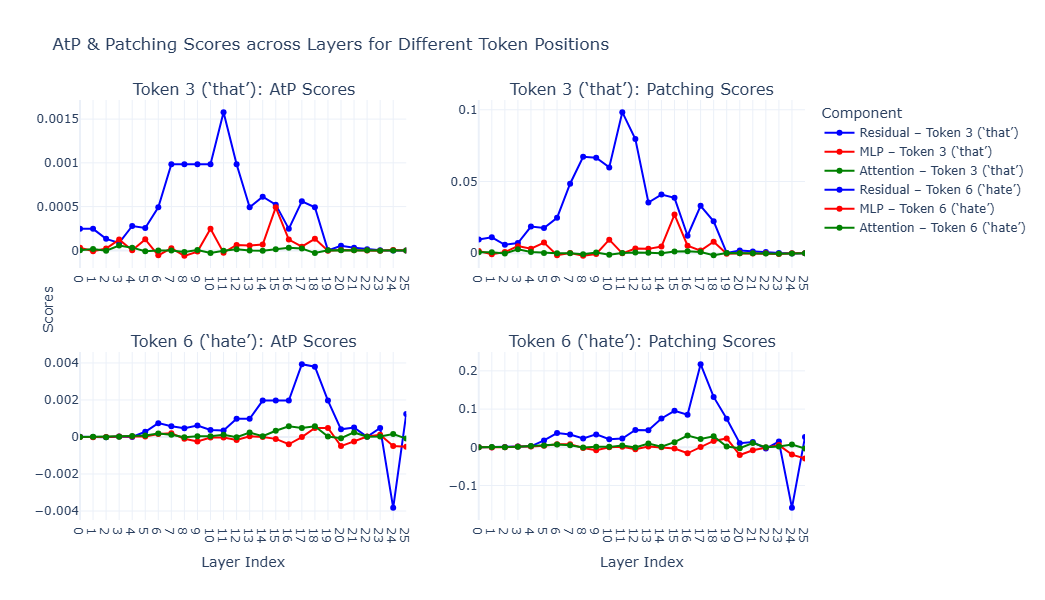

In [62]:
plot_scores(
    resid_sfc_scores, 
    mlp_sfc_scores, 
    attn_sfc_scores,
    resid_patching_scores, 
    mlp_patching_scores, 
    attn_patching_scores,
    token_positions=[3, 6]
)

### Plotting the AtP vs act. patching correlations

In [53]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import scipy.stats as stats
import plotly.io as pio

def plot_correlation_multi_tokens(
    sfc_scores, patching_scores, token_positions=None, node_type='Resid',
    prompt="BOS The girls that the assistants hate"
):
    """
    Plots scatter plots of sfc_values vs patching_values for multiple token positions,
    with regression lines and correlation coefficients, labeled by layer index.
    """
    token_list = prompt.split()
    if token_positions is None:
        token_positions = [None]

    subplot_titles = []
    token_labels = []

    for pos in token_positions:
        if pos is not None:
            try:
                token_str = token_list[pos]
            except IndexError:
                token_str = f"<pos {pos}>"
            token_labels.append(token_str)
            subplot_titles.append(f"{node_type} Nodes – Token {pos} (‘{token_str}’)")
        else:
            token_labels.append("Averaged")
            subplot_titles.append(f"{node_type} Nodes – Averaged over Tokens")

    fig = make_subplots(
        rows=len(token_positions), cols=1,
        shared_xaxes=False, shared_yaxes=False,
        subplot_titles=subplot_titles
    )

    for i, pos in enumerate(token_positions):
        if pos is not None:
            try:
                token_str = token_list[pos]
            except IndexError:
                token_str = f"<pos {pos}>"
            position_desc = f"Token {pos} (‘{token_str}’)"
            sfc_values = [tensor[pos].float().cpu().numpy() for tensor in sfc_scores]
            patching_values = [tensor[pos].float().cpu().numpy() for tensor in patching_scores]
        else:
            position_desc = "Averaged over tokens"
            sfc_values = [tensor.float().mean(dim=0).cpu().numpy() for tensor in sfc_scores]
            patching_values = [tensor.float().mean(dim=0).cpu().numpy() for tensor in patching_scores]

        r_value, _ = stats.pearsonr(sfc_values, patching_values)
        slope, intercept, *_ = stats.linregress(sfc_values, patching_values)
        regression_line = [slope * x + intercept for x in sfc_values]
        layer_indices = list(range(len(sfc_values)))

        # Scatter plot
        fig.add_trace(go.Scatter(
            x=sfc_values, y=patching_values,
            mode='markers+text',
            name=f'{position_desc} (r={r_value:.2f})',
            marker=dict(color="rgba(50, 100, 250, 0.8)", size=8),
            text=[str(i) for i in layer_indices],
            textposition='top center',
            textfont=dict(size=9, color="rgba(50, 50, 50, 0.6)")
        ), row=i+1, col=1)

        # Regression line
        fig.add_trace(go.Scatter(
            x=sfc_values, y=regression_line,
            mode='lines',
            name=f'Regression ({position_desc})',
            line=dict(color="rgba(200, 50, 50, 0.9)", width=2),
            showlegend=False
        ), row=i+1, col=1)

        # Update the annotation title with correlation
        fig.layout.annotations[i].text = f"{node_type} Nodes – {position_desc} (r = {r_value:.2f})"

    fig.update_layout(
        height=350 * len(token_positions),
        title_text=f"{node_type} Node Correlations across Token Positions",
        showlegend=False,
        template='plotly_white'
    )

    fig.update_xaxes(title_text="AtP Scores", row=len(token_positions), col=1)
    # Shared y-axis label as vertical annotation
    fig.add_annotation(
        text="Patching Scores",
        xref="paper", yref="paper",
        x=-0.07, y=0.5,
        showarrow=False,
        textangle=-90,
        font=dict(size=14)
    )
    
    pio.write_image(fig, "correlation_multi_tokens.png", format='png', scale=3, width=1000, height=350 * len(token_positions))
    fig.show()

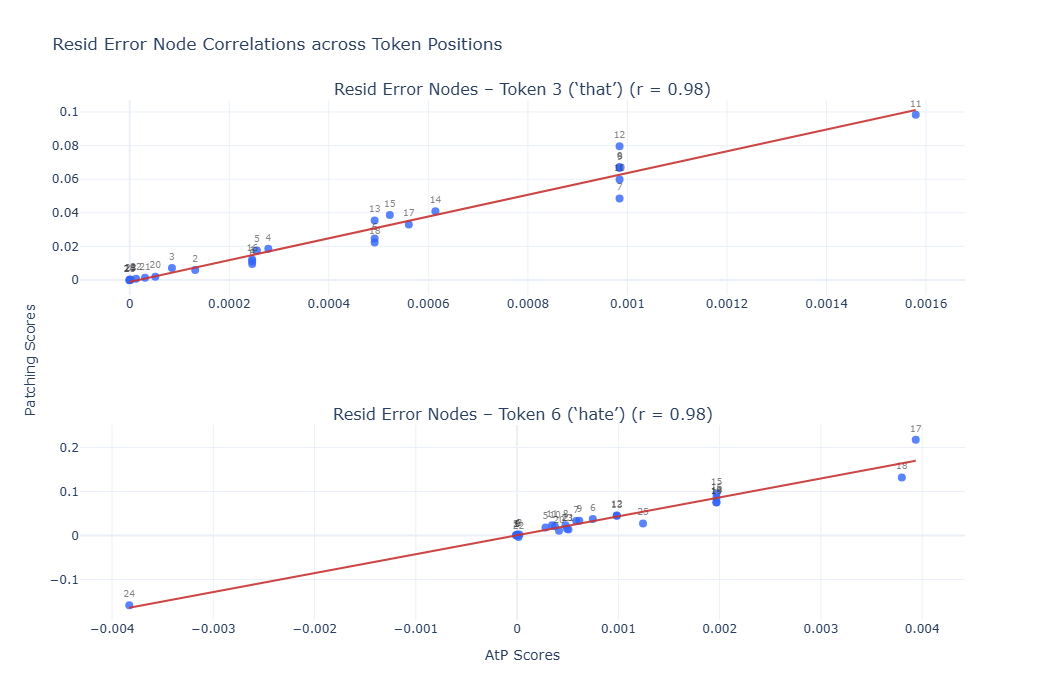

In [54]:
plot_correlation_multi_tokens(resid_sfc_scores, resid_patching_scores, 
                              token_positions=[3, 6],
                              node_type='Resid Error')

In [ ]:
plot_correlation(mlp_sfc_scores, mlp_patching_scores, token_position=-2, node_type='MLP')

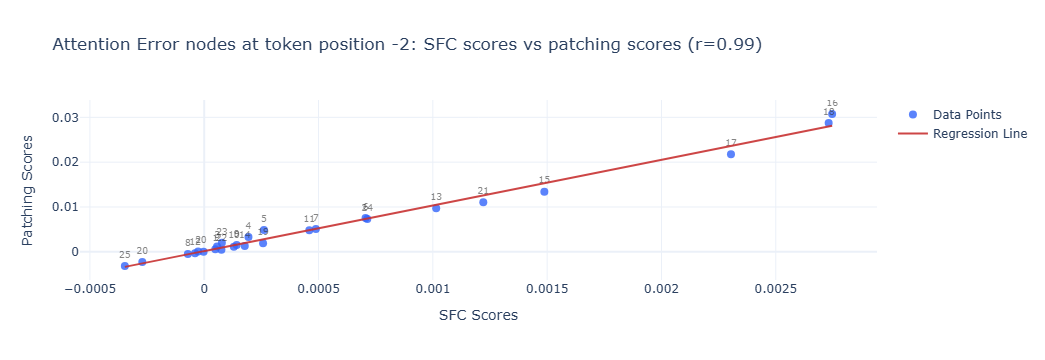

In [26]:
plot_correlation(attn_sfc_scores, attn_patching_scores, token_position=-2, node_type='Attention')

Life is good! The correlation of our AtP scores with the "ground truth" patching scores is almost perfect in all cases

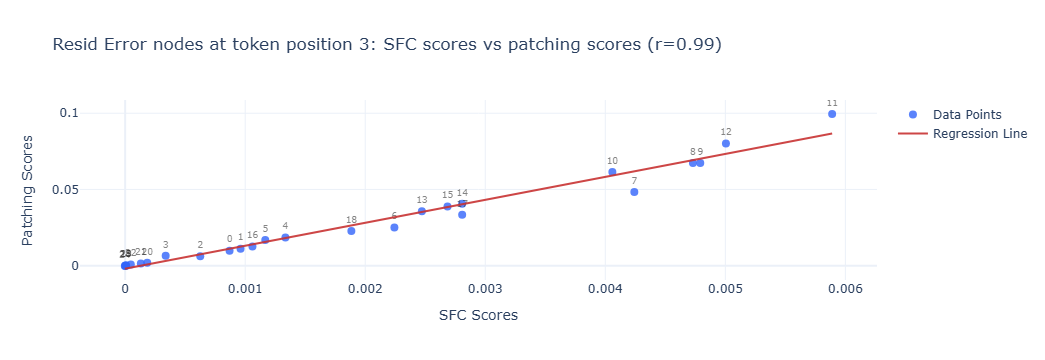

In [27]:
plot_correlation(resid_sfc_scores, resid_patching_scores, token_position=3)